In [1]:
# libs
import xarray as xr
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature


# not using this one, but it is useful when multiple stations
#from scipy.spatial import cKDTree

In [2]:
mp9_bl1_path = '/glade/derecho/scratch/jhenao/atm746/ar_mp9_bl1/'


mp9_bl1_files = sorted(glob.glob(mp9_bl1_path+"wrfout_d02*"))


In [3]:
ds_mp9_bl1 = xr.open_mfdataset(mp9_bl1_files, combine='nested', concat_dim='Time')

In [31]:
lat = ds_mp9_bl1['XLAT'].isel(Time=0) 
lon = ds_mp9_bl1['XLONG'].isel(Time=0)

In [52]:
surface_temp = ds_mp9_bl1.T2
surface_temp

<xarray.DataArray 'T2' (Time: 145, south_north: 324, west_east: 282)> Size: 53MB
dask.array<concatenate, shape=(145, 324, 282), dtype=float32, chunksize=(1, 162, 141), chunktype=numpy.ndarray>
Coordinates:
    XLAT     (Time, south_north, west_east) float32 53MB dask.array<chunksize=(1, 162, 141), meta=np.ndarray>
    XLONG    (Time, south_north, west_east) float32 53MB dask.array<chunksize=(1, 162, 141), meta=np.ndarray>
    XTIME    (Time) datetime64[ns] 1kB dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: Time, south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  TEMP at 2 M
    units:        K
    stagger:

'2024-11-18 22:00:00'

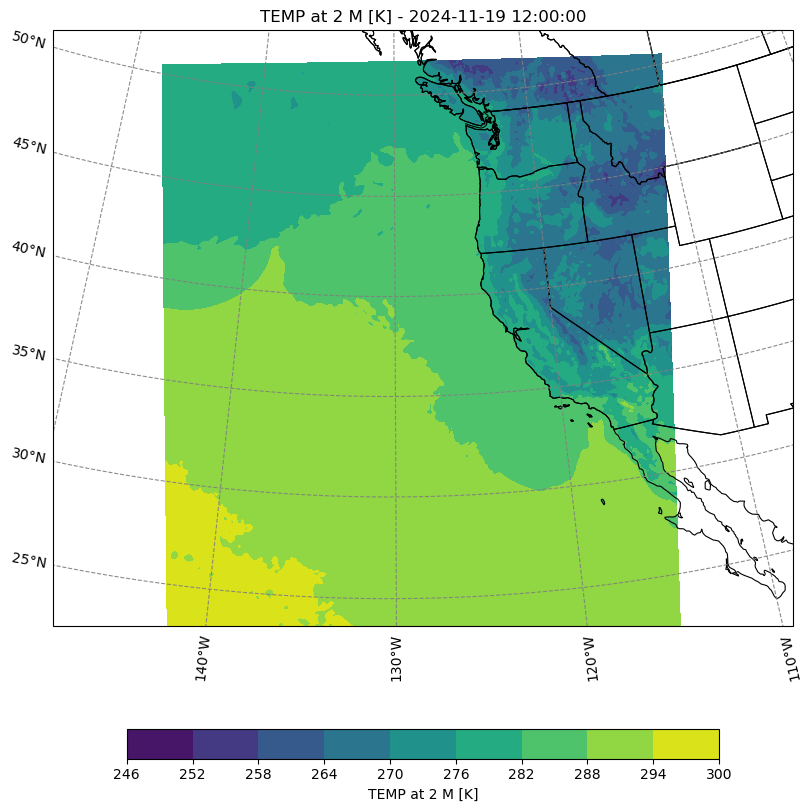

In [64]:
## plot a regional map and 
## add contour lines

lon_min = lon.min()
lon_max = lon.max()
lat_min = lat.min()
lat_max = lat.max()

time_index = 24 #get hour 10


surface_temp_time = surface_temp.isel(Time=time_index)
time_str = ds_mp9_bl1['XTIME'].dt.strftime("%Y-%m-%d %H:%M:%S").values[time_index]
var = surface_temp_time.description
units = surface_temp_time.units

# a Lambert projection using ref lat and lon from namelist.wps
projection = ccrs.LambertConformal(central_longitude=-130.392, central_latitude=35.174)

fig, ax = plt.subplots(
    figsize=(8, 8), 
    subplot_kw={"projection": projection}, 
    constrained_layout=True
)

## bounding box limits
ax.set_extent([lon_min, lon_max, lat_min, lat_max]) 

# add coastline, states and borders
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.STATES, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.8)

contours = ax.contourf(
    lon, lat, surface_temp_time,
    cmap='viridis',
    transform=ccrs.PlateCarree()
)

cbar = fig.colorbar(contours, ax=ax, orientation='horizontal', pad=0.07, shrink=0.8)
cbar.set_label(f"{var} [{units}]")
    
grid = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False,
                    color='gray', alpha=0.9, linestyle='--')

grid.top_labels = False
grid.right_labels = False


ax.set_title(f"{var} [{units}] - {time_str}")

plt.show()

In [65]:

# coords of station LAYTONVILLE
sta_lat = 39.702330
sta_lon = -123.484910

# Compute distance (squared) to every grid point
dist_sq = (lat - sta_lat)**2 + (lon - sta_lon)**2

In [66]:
# get the indexes lat, lon of the closest grid
iy, ix = np.unravel_index(np.argmin(dist_sq.values), dist_sq.shape)


In [67]:
# add convective and parameterized precip
t2_station = surface_temp.isel(south_north=iy, west_east=ix).values

In [69]:
times = surface_temp['XTIME'].values

In [70]:
# create a pandas dataframe
df_t2 = pd.DataFrame({'Date': times, 'T2': t2_station})
df_t2['Date'] = pd.to_datetime(df_t2['Date']).dt.tz_localize(None)

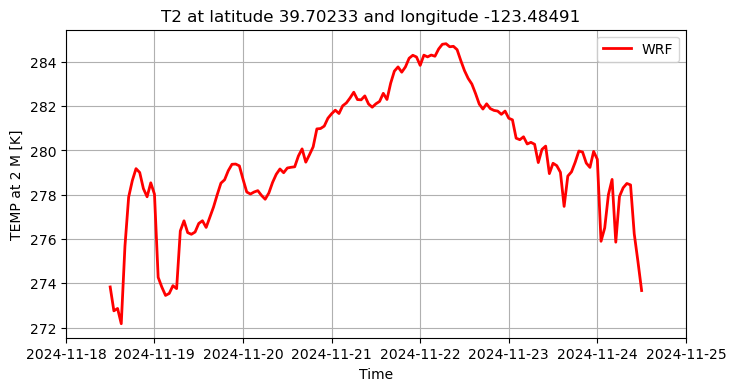

In [73]:
plt.figure(figsize=(8, 4))

plt.xlim(pd.Timestamp("2024-11-18"), pd.Timestamp("2024-11-25"))


plt.plot(df_t2['Date'], df_t2['T2'], label="WRF", linewidth=2, color='red')

plt.xlabel('Time')
plt.ylabel(f"{var} [{units}]")
plt.title(f"T2 at latitude {sta_lat} and longitude {sta_lon}  ")

plt.legend()

plt.grid(True)